### Bibliotecas

In [68]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.patches import FancyArrow   
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm

### Definições

In [9]:
diretorio_raiz = '/Volumes/MiniArmstro/Resultados/Processamento'
diretório_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023'
pacotes = '/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/pacotes.simul_2023_1120.xls'
raster_poligono_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Rain_mask_Sao_Paulo.tif'
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True

# Configurações iniciais do OSMnx
ox.settings.log_console = True
ox.settings.use_cache = True

In [3]:
# Define o local de interesse
place = "São Paulo, Brazil"

# Baixa a rede direcionada para análise de mão única
G = ox.graph_from_place(place, network_type='drive', retain_all=True)

# Número total de nós (interseções)
num_nodes = len(G.nodes)

# Número total de arestas (segmentos direcionais)
num_edges = len(G.edges)

# Contar quantas arestas têm 'oneway=True'
oneway_edges = [1 for _, _, _, data in G.edges(keys=True, data=True) if data.get("oneway") is True]
num_oneway_edges = sum(oneway_edges)

# Percentual de vias com mão única
percent_oneway = (num_oneway_edges / num_edges) * 100

# Exibe os resultados
print(f"Nós (interseções): {num_nodes}")
print(f"Arestas totais: {num_edges}")
print(f"Arestas com mão única: {num_oneway_edges}")
print(f"Percentual de mão única: {percent_oneway:.2f}%")



Nós (interseções): 122104
Arestas totais: 302839
Arestas com mão única: 54515
Percentual de mão única: 18.00%


In [14]:
# 1. Carregar o shapefile das subprefeituras de São Paulo
# Substitua pelo caminho do seu shapefile
gdf_subs = gpd.read_file(subprefeituras_shp)

# Atribuir o CRS correto se estiver ausente
if gdf_subs.crs is None:
    gdf_subs.set_crs(epsg=31983, inplace=True)  # SIRGAS 2000 / UTM 23S

# Reprojetar para WGS 84 (usado pelo OSMnx)
gdf_subs = gdf_subs.to_crs(epsg=4326)

# Verificar nomes das colunas
# print(gdf_subs.columns)

# Substitua abaixo pelo nome correto da coluna de identificação
nome_coluna = 'sp_nome'  # Ex: 'NOME', 'SUBPREF', etc.

In [17]:
# Inicializar lista para resultados
estatisticas = []

# 2. Loop pelas subprefeituras para coletar estatísticas
for idx, row in tqdm(gdf_subs.iterrows(), total=len(gdf_subs), desc="Processando subprefeituras"):
    nome = row[nome_coluna] if nome_coluna in row else f'Subpref_{idx}'
    print(f"Processando: {nome}")

    poligono = row.geometry
    
    try:
        # Baixar rede viária motorizável do OSM
        grafo = ox.graph_from_polygon(poligono, network_type='drive')

        gdf_nodes, gdf_edges = ox.graph_to_gdfs(grafo)

        # Reprojetar geometria temporariamente para calcular área em m²
        poligono_proj = gpd.GeoSeries([poligono], crs=4326).to_crs(epsg=3857).iloc[0]
        area_km2 = poligono_proj.area / 1e6

        # Reprojetar arestas para calcular comprimento
        total_km = gdf_edges.to_crs(epsg=3857).length.sum() / 1000
        densidade_viaria = total_km / area_km2 if area_km2 > 0 else 0

        estatisticas.append({
            'subprefeitura': nome,
            'area_km2': area_km2,
            'num_nos': len(gdf_nodes),
            'num_arestas': len(gdf_edges),
            'km_lineares': total_km,
            'densidade_viaria': densidade_viaria
        })

    except Exception as e:
        print(f"Erro na subprefeitura {nome}: {e}")

# Criar DataFrame final
df_resultado = pd.DataFrame(estatisticas)

# Juntar com o GeoDataFrame original para o mapa temático
gdf_resultado = gdf_subs.merge(df_resultado, left_on=nome_coluna, right_on='subprefeitura')

Processando subprefeituras:   0%|          | 0/32 [00:00<?, ?it/s]

Processando: FREGUESIA-BRASILANDIA


Processando subprefeituras:   3%|▎         | 1/32 [00:06<03:15,  6.29s/it]

Processando: CASA VERDE-CACHOEIRINHA


Processando subprefeituras:   6%|▋         | 2/32 [00:11<02:46,  5.55s/it]

Processando: LAPA


Processando subprefeituras:   9%|▉         | 3/32 [00:18<02:57,  6.12s/it]

Processando: PERUS


Processando subprefeituras:  12%|█▎        | 4/32 [00:22<02:31,  5.43s/it]

Processando: SE


Processando subprefeituras:  16%|█▌        | 5/32 [00:26<02:17,  5.09s/it]

Processando: SANTANA-TUCURUVI


Processando subprefeituras:  19%|█▉        | 6/32 [00:32<02:20,  5.40s/it]

Processando: PINHEIROS


Processando subprefeituras:  22%|██▏       | 7/32 [00:38<02:16,  5.45s/it]

Processando: JACANA-TREMEMBE


Processando subprefeituras:  25%|██▌       | 8/32 [00:45<02:21,  5.88s/it]

Processando: VILA MARIA-VILA GUILHERME


Processando subprefeituras:  28%|██▊       | 9/32 [00:50<02:09,  5.62s/it]

Processando: MOOCA


Processando subprefeituras:  31%|███▏      | 10/32 [00:55<02:02,  5.57s/it]

Processando: IPIRANGA


Processando subprefeituras:  34%|███▍      | 11/32 [01:01<01:56,  5.56s/it]

Processando: VILA MARIANA


Processando subprefeituras:  38%|███▊      | 12/32 [01:06<01:46,  5.31s/it]

Processando: PENHA


Processando subprefeituras:  41%|████      | 13/32 [01:12<01:49,  5.75s/it]

Processando: ERMELINO MATARAZZO


Processando subprefeituras:  44%|████▍     | 14/32 [01:16<01:29,  4.98s/it]

Processando: SAO MIGUEL


Processando subprefeituras:  47%|████▋     | 15/32 [01:21<01:25,  5.03s/it]

Processando: ITAQUERA


Processando subprefeituras:  50%|█████     | 16/32 [01:28<01:32,  5.80s/it]

Processando: ARICANDUVA-FORMOSA-CARRAO


Processando subprefeituras:  53%|█████▎    | 17/32 [01:33<01:22,  5.50s/it]

Processando: SAO MATEUS


Processando subprefeituras:  56%|█████▋    | 18/32 [01:41<01:25,  6.11s/it]

Processando: VILA PRUDENTE


Processando subprefeituras:  59%|█████▉    | 19/32 [01:44<01:08,  5.28s/it]

Processando: SAPOPEMBA


Processando subprefeituras:  62%|██████▎   | 20/32 [01:48<00:58,  4.86s/it]

Processando: PARELHEIROS


Processando subprefeituras:  66%|██████▌   | 21/32 [01:56<01:05,  5.96s/it]

Processando: CAMPO LIMPO


Processando subprefeituras:  69%|██████▉   | 22/32 [02:05<01:07,  6.78s/it]

Processando: CAPELA DO SOCORRO


Processando subprefeituras:  72%|███████▏  | 23/32 [02:16<01:11,  7.98s/it]

Processando: CIDADE ADEMAR


Processando subprefeituras:  75%|███████▌  | 24/32 [02:22<00:58,  7.29s/it]

Processando: JABAQUARA


Processando subprefeituras:  78%|███████▊  | 25/32 [02:25<00:42,  6.06s/it]

Processando: SANTO AMARO


Processando subprefeituras:  81%|████████▏ | 26/32 [02:30<00:35,  5.84s/it]

Processando: ITAIM PAULISTA


Processando subprefeituras:  84%|████████▍ | 27/32 [02:35<00:27,  5.54s/it]

Processando: GUAIANASES


Processando subprefeituras:  88%|████████▊ | 28/32 [02:40<00:21,  5.30s/it]

Processando: CIDADE TIRADENTES


Processando subprefeituras:  91%|█████████ | 29/32 [02:42<00:13,  4.54s/it]

Processando: BUTANTA


Processando subprefeituras:  94%|█████████▍| 30/32 [02:51<00:11,  5.86s/it]

Processando: PIRITUBA-JARAGUA


Processando subprefeituras:  97%|█████████▋| 31/32 [02:59<00:06,  6.54s/it]

Processando: M BOI MIRIM


Processando subprefeituras: 100%|██████████| 32/32 [03:07<00:00,  5.86s/it]


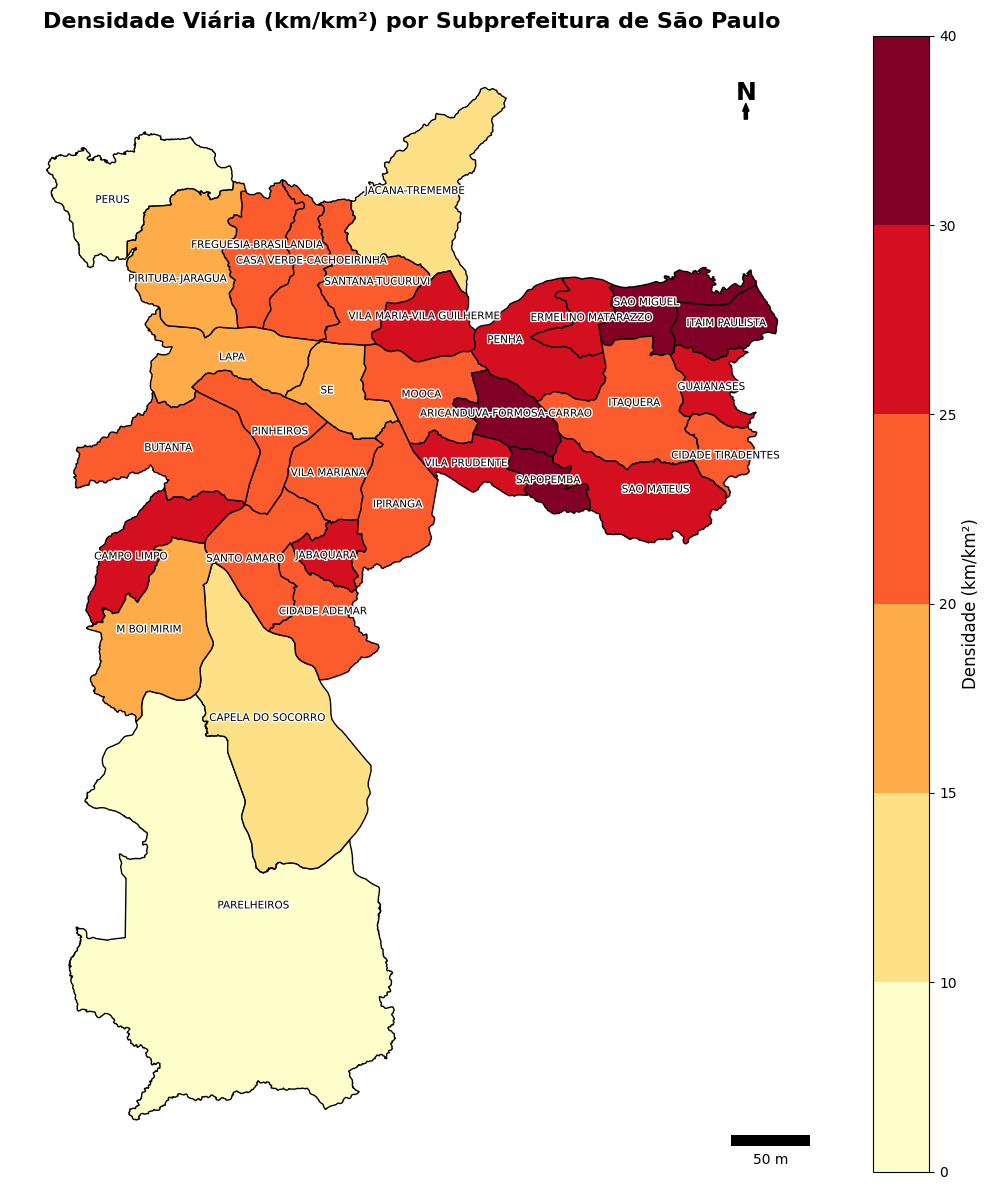

In [71]:
# 3. Mapa temático com a densidade viária

# Escolher paleta de cores mais contrastante
cmap_cores = 'YlOrRd'  # Outras opções: 'plasma', 'magma', 'cividis'
norm = Normalize(vmin=gdf_resultado['densidade_viaria'].min(), vmax=gdf_resultado['densidade_viaria'].max())

fig, ax = plt.subplots(figsize=(12, 12))

bins = [0, 10, 15, 20, 25, 30, 40]
norm = BoundaryNorm(bins, ncolors=256)

# Plot do mapa
gdf_resultado.plot(
    column='densidade_viaria',
    cmap=cmap_cores,
    norm=norm,
    legend=False,
    ax=ax,
    edgecolor='black'
)

# Adicionar título
ax.set_title('Densidade Viária (km/km²) por Subprefeitura de São Paulo', fontsize=16, weight='bold')

ajustes = {
    'SAO MIGUEL': (0.000, 0.006),
    'ITAQUERA': (0.015, 0.000),
    'PINHEIROS': (0.000, 0.007),
    'SANTANA-TUCURUVI': (0.000, -0.006),
    'FREGUESIA-BRASILANDIA': (0.000, 0.006),
    'PIRITUBA-JARAGUA': (0.000, -0.012),    # adicione outras que achar necessário
}

for idx, row in gdf_resultado.iterrows():
    nome = row[nome_coluna]
    x, y = row.geometry.representative_point().x, row.geometry.representative_point().y
    dx, dy = ajustes.get(nome, (0, 0))  # usa deslocamento personalizado se existir
    ax.text(
        x + dx, y + dy, nome,
        ha='center', va='center', fontsize=7.5, color='black',
        path_effects=[path_effects.withStroke(linewidth=2, foreground='white')]
    )


# Seta de norte com FancyArrow
xmin, ymin, xmax, ymax = gdf_resultado.total_bounds
arrow_x = xmax - 0.02
arrow_y = ymax - 0.02
ax.add_patch(FancyArrow(x=arrow_x, y=arrow_y, dx=0, dy=0.01,
                        width=0.002, head_width=0.004, head_length=0.005,
                        length_includes_head=True, color='black'))
ax.text(arrow_x, arrow_y + 0.012, 'N', fontsize=18, fontweight='bold', ha='center')

# Colorbar manual
sm = ScalarMappable(cmap=cmap_cores, norm=norm)
sm.set_array([])  # necessário para a colorbar funcionar
cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Densidade (km/km²)', fontsize=12)

scalebar = ScaleBar(1, units='km', dimension='si-length', location='lower right', scale_loc='bottom', length_fraction=0.1)
ax.add_artist(scalebar)

# Remover eixos
ax.axis('off')
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


### Visualização das datas

In [73]:
arquivo_pacotes = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/My Drive/pacotes.simul_2023_1120.xls'

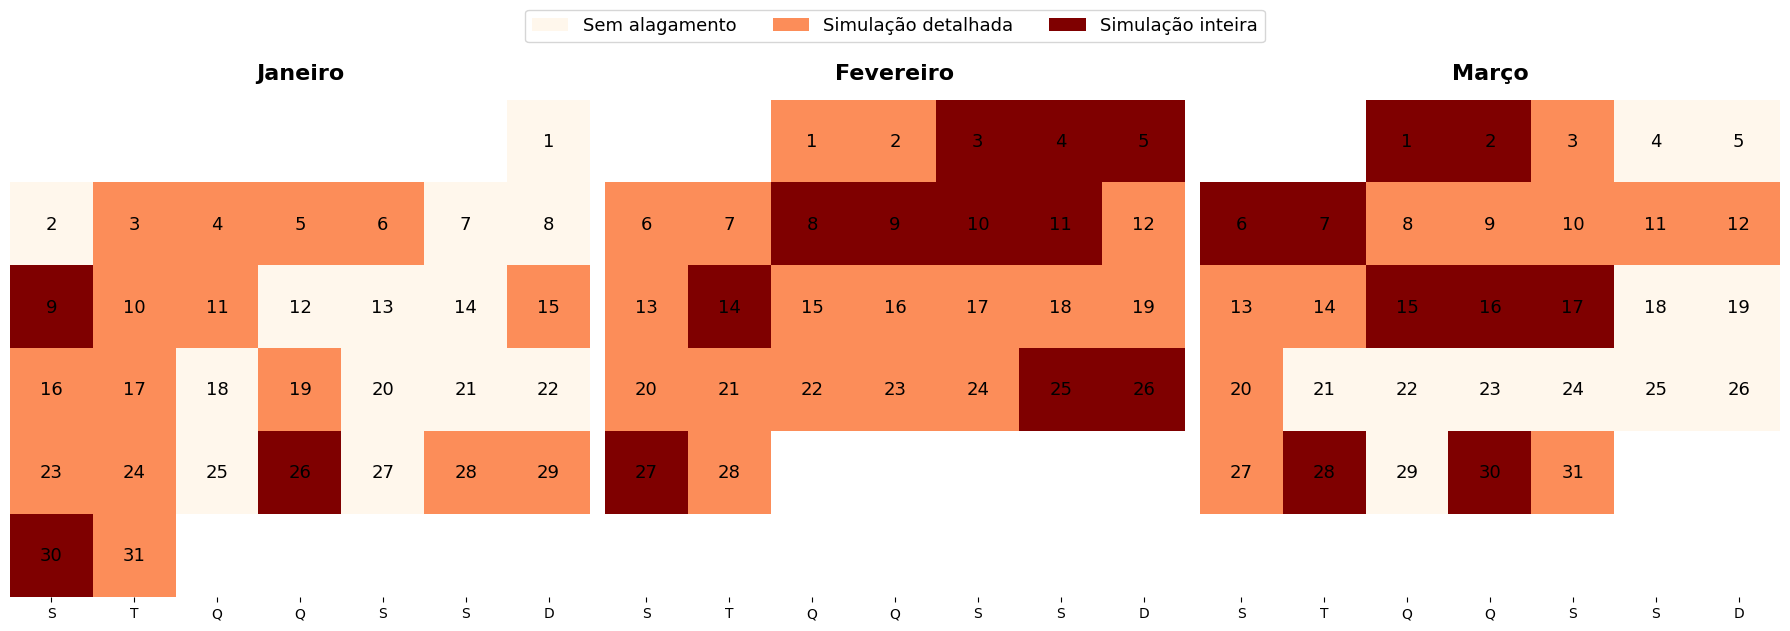

In [122]:
# Ler a planilha usando o engine xlrd (necessário para arquivos .xls)
df_real = pd.read_excel(arquivo_pacotes, sheet_name="pacotes.simul_2023_1120", engine="xlrd")

col_data = 'Data evento'  # Nome da coluna com a data do pacote
col_tipo = 'Tipo'  # Nome da coluna que indica se é 'Detalhado' ou 'Inteiro'

# Garantir formato datetime
df[col_data] = pd.to_datetime(df[col_data], errors='coerce')
df = df.dropna(subset=[col_data, col_tipo])

# 1. Garantir que a coluna de datas está em datetime
df_real["Data evento"] = pd.to_datetime(df_real["Data evento"], errors="coerce")

# 2. Filtrar apenas os meses desejados
df_real = df_real[
    df_real["Data evento"].dt.month.isin([1, 2, 3]) &
    (df_real["Data evento"].dt.year == 2023)
]

# 3. Mapear os tipos para códigos numéricos
tipo_to_codigo = {"Detalhado": 1, "Inteiro": 2}
flood_data_real = {
    row["Data evento"].date(): tipo_to_codigo.get(row["Tipo"], 0)
    for _, row in df_real.iterrows()
}

# 4. Atualizar o DataFrame de calendário com os dados reais
df_calendar["flood_code"] = df_calendar["date"].dt.date.map(flood_data_real).fillna(0).astype(int)

# Regerar o gráfico final com os dados reais integrados
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, month in enumerate(months):
    ax = axes[i]
    month_df = df_calendar[df_calendar["month"] == month]

    # Pivot com preenchimento para alinhar altura
    pivot = pd.pivot_table(
        month_df,
        index="week",
        columns="weekday",
        values="flood_code",
        aggfunc="first",
        fill_value=np.nan
    )
    day_pivot = pd.pivot_table(
        month_df,
        index="week",
        columns="weekday",
        values="day",
        aggfunc="first",
        fill_value=np.nan
    )

    # Padding para igualar alturas
    while pivot.shape[0] < max_weeks:
        empty_row = pd.Series([np.nan] * 7, index=pivot.columns, name=pivot.index.max() + 1)
        pivot = pd.concat([pivot, empty_row.to_frame().T])
        day_pivot = pd.concat([day_pivot, empty_row.to_frame().T])

    cmap = matplotlib.colormaps.get_cmap("OrRd").resampled(3)
    im = ax.imshow(pivot, cmap=cmap, vmin=0, vmax=2)

    ax.set_title(
        month_names_pt[month],
        fontsize=16,
        fontweight='bold',
        loc='center',
        pad=15
    )

    ax.set_xticks(range(7))
    ax.set_xticklabels(["S", "T", "Q", "Q", "S", "S", "D"])
    ax.set_yticks([])

    for y in range(pivot.shape[0]):
        for x in range(pivot.shape[1]):
            day_num = day_pivot.iloc[y, x]
            if not np.isnan(day_num):
                ax.text(x, y, str(int(day_num)), va='center', ha='center', fontsize=13, color='black')

    for edge in ["top", "right", "left", "bottom"]:
        ax.spines[edge].set_visible(False)

# Legenda
legend_elements = [
    Patch(facecolor=cmap(0), label="Sem alagamento"),
    Patch(facecolor=cmap(1), label="Simulação detalhada"),
    Patch(facecolor=cmap(2), label="Simulação inteira"),
]
fig.legend(handles=legend_elements, loc="upper center", ncol=3, 
    bbox_to_anchor=(0.5, 1.08),
    fontsize=13)

#fig.suptitle("Alagamentos em Jan-Mar 2023", fontsize=16)
plt.tight_layout()
plt.show()
